In [ ]:
import keras
import numpy as np 
import pandas as pd 
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import os
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import DataLoader
from torch.nn.functional import normalize
import torchvision

from keras_preprocessing.image import img_to_array
from keras_preprocessing.image import load_img

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/My Drive
%cd UTA/5334/ImageClassifier

/content/drive/My Drive
/content/drive/My Drive/UTA/5334/ImageClassifier


In [ ]:
import os
img_data_dir = 'caltech101_classification'
print("img_data_dir: ",img_data_dir)
print("Total Number of Images of different class:")
print("# of Airplane:",len(os.listdir(os.path.join(img_data_dir,'airplanes'))))
print("# of Motorbikes:",len(os.listdir(os.path.join(img_data_dir,'Motorbikes'))))
print("# of Schooner:",len(os.listdir(os.path.join(img_data_dir,'schooner'))))

img_data_dir:  caltech101_classification
Total Number of Images of different class:
# of Airplane: 800
# of Motorbikes: 798
# of Schooner: 63


Loading Images into Training and Validation Dataset having split ratio of 80:20
Batch Size: 10
Image Size :  240x240

In [ ]:
#Reference : (https://discuss.pytorch.org/t/how-to-split-dataset-into-test-and-validation-sets/33987/4)
def train_val_dataset(dataset, val_split=0.20):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

dataset = ImageFolder(img_data_dir, transform=Compose([Resize((240,240)),ToTensor()]))
print("Total Number of Images",len(dataset))
datasets = train_val_dataset(dataset)
print("Total Number of Images in Training Dataset ",len(datasets['train']))
print("Total Number of Images in Validation Dataset ",len(datasets['val']))
print("Dataset Information ",datasets['train'].dataset)

dataloaders = {x:DataLoader(datasets[x],4, shuffle=True) for x in ['train','val']}
x,y = next(iter(dataloaders['train']))
print(x.shape, y.shape)

Total Number of Images 1661
Total Number of Images in Training Dataset  1328
Total Number of Images in Validation Dataset  333
Dataset Information  Dataset ImageFolder
    Number of datapoints: 1661
    Root location: caltech101_classification
    StandardTransform
Transform: Compose(
               Resize(size=(240, 240), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )
torch.Size([4, 3, 240, 240]) torch.Size([4])


Save Training and Validation dataset in their respective folder

In [ ]:
classes = ('Motorbikes', 'airplanes', 'schooner')
print(classes)
batch_size = 4

('Motorbikes', 'airplanes', 'schooner')


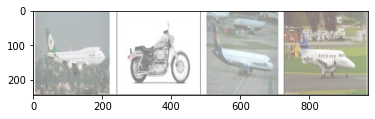

airplanes Motorbikes airplanes airplanes


In [ ]:
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(dataloaders['train']) # Modification to map dataloader
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)
import torch.nn as nn
import torch.nn.functional as F


class BaseNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.pool = nn.AdaptiveAvgPool2d(3)
        self.conv2 = nn.Conv2d(6, 12, 3)
        self.fc1 = nn.Linear(12 * 3 * 3, 240)
        self.fc2 = nn.Linear(240, 120)
        self.fc3 = nn.Linear(120, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = BaseNet()

In [ ]:
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(dataloaders['train'], 0): # Modification to map dataloader
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 2000 mini-batches
            print(f'[epoch : {epoch + 1}, mini-batches : {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training Base Model')

[epoch : 1, mini-batches :   100] loss: 0.107
[epoch : 1, mini-batches :   200] loss: 0.070
[epoch : 1, mini-batches :   300] loss: 0.044
[epoch : 2, mini-batches :   100] loss: 0.043
[epoch : 2, mini-batches :   200] loss: 0.041
[epoch : 2, mini-batches :   300] loss: 0.043
Finished Training Base Model


In [ ]:
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)
PATH = './image_classifier.pth'
torch.save(net.state_dict(), PATH)

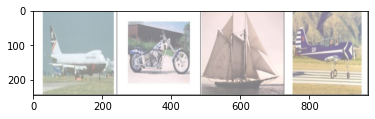

GroundTruth:  airplanes Motorbikes schooner airplanes


In [ ]:
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)

dataiter = iter(dataloaders['train']) # Modification to map dataloader
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)
net = BaseNet()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)

outputs = net(images)

In [ ]:
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  airplanes airplanes airplanes airplanes


In [ ]:
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in dataloaders['val']: # Modification to map dataloader
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
first_model_accuracy = 100 * correct // total # Modification
print("Accuracy of the First Network on the validation images:", first_model_accuracy ,'%') # Modification

Accuracy of the First Network on the validation images: 47 %


Accuracy for class: Motorbikes is 0.0 %
Accuracy for class: airplanes is 100.0 %
Accuracy for class: schooner is 0.0 %


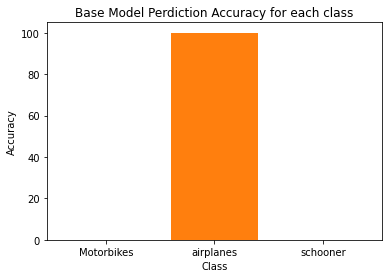

In [ ]:
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in dataloaders['val']: # Modification to map dataloader
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    class_accuracy = 100 * float(correct_count) / total_pred[classname] # Modification to map dataloader
    print(f'Accuracy for class: {classname:5s} is {class_accuracy:.1f} %')

    # Plot graph for each class Airplane, Motorbikes, Schooner
    plt.title("Base Model Perdiction Accuracy for each class")
    plt.xlabel("Class")
    plt.ylabel("Accuracy")
    plt.bar(classname, class_accuracy)


In [ ]:
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)
import torch.nn as nn
import torch.nn.functional as F


class Model1Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 6) # Modification to Hyper-Parameters 
        self.pool = nn.AdaptiveAvgPool2d(6)
        self.conv2 = nn.Conv2d(16, 32, 6) # Modification to Hyper-Parameters
        self.fc1 = nn.Linear(32 * 6 * 6, 120) # Modification to Hyper-Parameters
        self.fc2 = nn.Linear(120, 60) # Modification to Hyper-Parameters
        self.fc3 = nn.Linear(60, 10) # Modification to Hyper-Parameters

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model1net = Model1Net()

In [ ]:
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model1net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)
for epoch in range(5):  # let's run for 5 epochs 

    running_loss = 0.0
    for i, data in enumerate(dataloaders['train'], 0): # Modification to map dataloader
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model1net(inputs) # Modification to map to Model 1 
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print(f'[epoch : {epoch + 1}, mini-batches : {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training Model 1')

[epoch : 1, mini-batches :   100] loss: 0.081
[epoch : 1, mini-batches :   200] loss: 0.043
[epoch : 1, mini-batches :   300] loss: 0.030
[epoch : 2, mini-batches :   100] loss: 0.025
[epoch : 2, mini-batches :   200] loss: 0.021
[epoch : 2, mini-batches :   300] loss: 0.022
[epoch : 3, mini-batches :   100] loss: 0.022
[epoch : 3, mini-batches :   200] loss: 0.017
[epoch : 3, mini-batches :   300] loss: 0.017
[epoch : 4, mini-batches :   100] loss: 0.016
[epoch : 4, mini-batches :   200] loss: 0.018
[epoch : 4, mini-batches :   300] loss: 0.015
[epoch : 5, mini-batches :   100] loss: 0.014
[epoch : 5, mini-batches :   200] loss: 0.017
[epoch : 5, mini-batches :   300] loss: 0.019
Finished Training Model 1


In [ ]:
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in dataloaders['val']: # Modification to map dataloader
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model1net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
second_model_accuracy = 100 * correct // total
print("Accuracy of the Second Network on the validation images:", second_model_accuracy ,'%')

Accuracy of the Second Network on the validation images: 85 %


Accuracy for class: Motorbikes is 96.5 %
Accuracy for class: airplanes is 80.5 %
Accuracy for class: schooner is 50.0 %


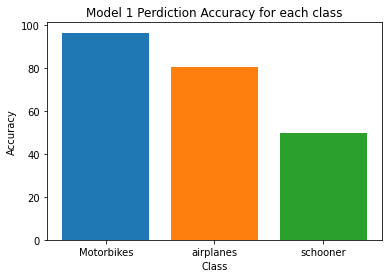

In [ ]:
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in dataloaders['val']: # Modification to map dataloader
        images, labels = data
        outputs = model1net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    class_accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {class_accuracy:.1f} %')

    # Plot graph for each class Airplane, Motorbikes, Schooner
    plt.title("Model 1 Perdiction Accuracy for each class")
    plt.xlabel("Class")
    plt.ylabel("Accuracy")
    plt.bar(classname, class_accuracy)

In [ ]:
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)
import torch.nn as nn
import torch.nn.functional as F


class Model2Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 6) # Modification to Hyper-Parameters 
        self.pool = nn.AdaptiveAvgPool2d(6)
        self.conv2 = nn.Conv2d(6, 12, 6) # Modification to Hyper-Parameters
        self.conv3 = nn.Conv2d(12, 24, 6) # Modification to Hyper-Parameters
        self.conv4 = nn.Conv2d(24, 48, 6) # Modification to Hyper-Parameters
        self.conv5 = nn.Conv2d(48, 96, 6) # Modification to Hyper-Parameters
        self.fc1 = nn.Linear(96 * 6 * 6, 160) # Modification to Hyper-Parameters
        self.fc2 = nn.Linear(160, 60) # Modification to Hyper-Parameters
        self.fc3 = nn.Linear(60, 10) # Modification to Hyper-Parameters

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model2net = Model2Net()

In [ ]:
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model2net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(10):  # let's run for 5 epochs 

    running_loss = 0.0
    for i, data in enumerate(dataloaders['train'], 0): # Modification to map dataloader
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model2net(inputs) # Modification to map to Model 1 
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print(f'[epoch : {epoch + 1}, mini-batches : {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training Model 2')

[epoch : 1, mini-batches :   100] loss: 0.107
[epoch : 1, mini-batches :   200] loss: 0.070
[epoch : 1, mini-batches :   300] loss: 0.045
[epoch : 2, mini-batches :   100] loss: 0.041
[epoch : 2, mini-batches :   200] loss: 0.037
[epoch : 2, mini-batches :   300] loss: 0.032
[epoch : 3, mini-batches :   100] loss: 0.025
[epoch : 3, mini-batches :   200] loss: 0.026
[epoch : 3, mini-batches :   300] loss: 0.023
[epoch : 4, mini-batches :   100] loss: 0.027
[epoch : 4, mini-batches :   200] loss: 0.021
[epoch : 4, mini-batches :   300] loss: 0.021
[epoch : 5, mini-batches :   100] loss: 0.020
[epoch : 5, mini-batches :   200] loss: 0.020
[epoch : 5, mini-batches :   300] loss: 0.019
[epoch : 6, mini-batches :   100] loss: 0.021
[epoch : 6, mini-batches :   200] loss: 0.020
[epoch : 6, mini-batches :   300] loss: 0.017
[epoch : 7, mini-batches :   100] loss: 0.022
[epoch : 7, mini-batches :   200] loss: 0.017
[epoch : 7, mini-batches :   300] loss: 0.015
[epoch : 8, mini-batches :   100] 

In [ ]:
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in dataloaders['val']: # Modification to map dataloader
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model2net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
third_model_accuracy = 100 * correct // total
print("Accuracy of the Third Network on the validation images:", third_model_accuracy ,'%')

Accuracy of the Third Network on the validation images: 86 %


Accuracy for class: Motorbikes is 92.3 %
Accuracy for class: airplanes is 89.7 %
Accuracy for class: schooner is 0.0 %


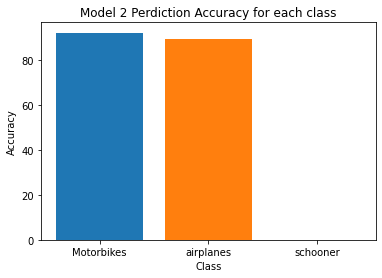

In [ ]:
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in dataloaders['val']: # Modification to map dataloader
        images, labels = data
        outputs = model2net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    class_accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {class_accuracy:.1f} %')

    # Plot graph for each class Airplane, Motorbikes, Schooner
    plt.title("Model 2 Perdiction Accuracy for each class")
    plt.xlabel("Class")
    plt.ylabel("Accuracy")
    plt.bar(classname, class_accuracy)

In [ ]:
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)
import torch.nn as nn
import torch.nn.functional as F


class Model3Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 6) # Modification to Hyper-Parameters 
        self.pool = nn.AdaptiveAvgPool2d(6) # Modification 
        self.conv2 = nn.Conv2d(6, 12, 6) # Modification to Hyper-Parameters
        self.conv3 = nn.Conv2d(12, 24, 6) # Modification to Hyper-Parameters
        self.conv4 = nn.Conv2d(24, 48, 6) # Addition of layer
        self.conv5 = nn.Conv2d(48, 96, 6) # Addition of layer
        self.conv6 = nn.Conv2d(96, 192, 6) # Addition of layer
        self.conv7 = nn.Conv2d(192, 384, 6) # Addition of layer
        self.conv8 = nn.Conv2d(384, 768, 6) # Addition of layer
        self.fc1 = nn.Linear(768 * 6 * 6, 512) # Modification to Hyper-Parameters
        self.fc2 = nn.Linear(512, 256) # Modification to Hyper-Parameters
        self.fc3 = nn.Linear(256, 128) # Modification to Hyper-Parameters
        self.fc4 = nn.Linear(128, 10) # Addition of layer

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = self.pool(F.relu(self.conv6(x)))
        x = self.pool(F.relu(self.conv7(x)))
        x = self.pool(F.relu(self.conv8(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x)) # Modification 
        x = self.fc4(x)
        return x


model3net = Model3Net()

In [ ]:
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model3net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(10):  # let's run for 5 epochs 

    running_loss = 0.0
    for i, data in enumerate(dataloaders['train'], 0): # Modification to map dataloader
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model3net(inputs) # Modification to map to Model 1 
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print(f'[epoch : {epoch + 1}, mini-batches : {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training Model 3')

[epoch : 1, mini-batches :   100] loss: 0.107
[epoch : 1, mini-batches :   200] loss: 0.088
[epoch : 1, mini-batches :   300] loss: 0.069
[epoch : 2, mini-batches :   100] loss: 0.052
[epoch : 2, mini-batches :   200] loss: 0.049
[epoch : 2, mini-batches :   300] loss: 0.043
[epoch : 3, mini-batches :   100] loss: 0.046
[epoch : 3, mini-batches :   200] loss: 0.040
[epoch : 3, mini-batches :   300] loss: 0.034
[epoch : 4, mini-batches :   100] loss: 0.042
[epoch : 4, mini-batches :   200] loss: 0.035
[epoch : 4, mini-batches :   300] loss: 0.034
[epoch : 5, mini-batches :   100] loss: 0.025
[epoch : 5, mini-batches :   200] loss: 0.024
[epoch : 5, mini-batches :   300] loss: 0.030
[epoch : 6, mini-batches :   100] loss: 0.024
[epoch : 6, mini-batches :   200] loss: 0.019
[epoch : 6, mini-batches :   300] loss: 0.022
[epoch : 7, mini-batches :   100] loss: 0.023
[epoch : 7, mini-batches :   200] loss: 0.020
[epoch : 7, mini-batches :   300] loss: 0.021
[epoch : 8, mini-batches :   100] 

In [ ]:
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in dataloaders['val']: # Modification to map dataloader
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model3net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
fourth_model_accuracy = 100 * correct // total
print("Accuracy of the Fourth Network on the validation images:", fourth_model_accuracy ,'%')

Accuracy of the Fourth Network on the validation images: 47 %


Accuracy for class: Motorbikes is 0.0 %
Accuracy for class: airplanes is 100.0 %
Accuracy for class: schooner is 0.0 %


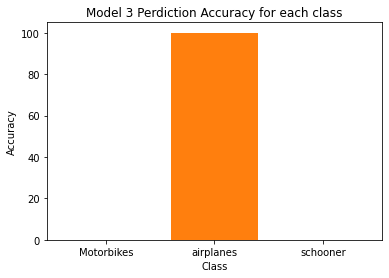

In [ ]:
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in dataloaders['val']: # Modification to map dataloader
        images, labels = data
        outputs = model3net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    class_accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {class_accuracy:.1f} %')

    # Plot graph for each class Airplane, Motorbikes, Schooner
    plt.title("Model 3 Perdiction Accuracy for each class")
    plt.xlabel("Class")
    plt.ylabel("Accuracy")
    plt.bar(classname, class_accuracy)

<BarContainer object of 4 artists>

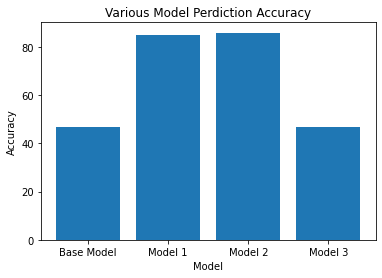

In [ ]:
# Plot graph for each class Airplane, Motorbikes, Schooner
plt.title("Various Model Perdiction Accuracy")
plt.xlabel("Model")
plt.ylabel("Accuracy")
x = ["Base Model", "Model 1", "Model 2", "Model 3"]
y = [first_model_accuracy,second_model_accuracy,third_model_accuracy,fourth_model_accuracy]
plt.bar(x, y)

In [ ]:
#Reference : (https://discuss.pytorch.org/t/how-to-split-dataset-into-test-and-validation-sets/33987/4)
def train_val_dataset(dataset, val_split=0.20):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

dataset = ImageFolder(img_data_dir, transform=Compose([Resize((100,100)),ToTensor()]))
print("Total Number of Images",len(dataset))
datasets = train_val_dataset(dataset)
print("Total Number of Images in Training Dataset ",len(datasets['train']))
print("Total Number of Images in Validation Dataset ",len(datasets['val']))
print("Dataset Information ",datasets['train'].dataset)

dataloaders = {x:DataLoader(datasets[x],10, shuffle=True) for x in ['train','val']}
x,y = next(iter(dataloaders['train']))
print(x.shape, y.shape)

Total Number of Images 1661
Total Number of Images in Training Dataset  1328
Total Number of Images in Validation Dataset  333
Dataset Information  Dataset ImageFolder
    Number of datapoints: 1661
    Root location: caltech101_classification
    StandardTransform
Transform: Compose(
               Resize(size=(100, 100), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )
torch.Size([10, 3, 100, 100]) torch.Size([10])


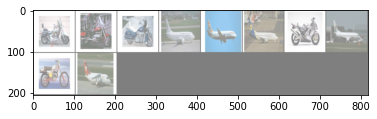

Motorbikes Motorbikes Motorbikes airplanes airplanes airplanes Motorbikes airplanes Motorbikes airplanes


In [ ]:
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)
batch_size = 10
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(dataloaders['train']) # Modification to map dataloader
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

[epoch : 1, mini-batches :   100] loss: 0.106
[epoch : 2, mini-batches :   100] loss: 0.065
Finished Training Base Model


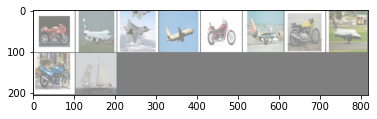

GroundTruth:  Motorbikes airplanes airplanes airplanes Motorbikes airplanes Motorbikes airplanes Motorbikes schooner
Predicted:  airplanes airplanes airplanes airplanes airplanes airplanes airplanes airplanes airplanes airplanes


In [ ]:
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)
import torch.nn as nn
import torch.nn.functional as F


class BaseNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.pool = nn.AdaptiveAvgPool2d(3)
        self.conv2 = nn.Conv2d(6, 12, 3)
        self.fc1 = nn.Linear(12 * 3 * 3, 240)
        self.fc2 = nn.Linear(240, 120)
        self.fc3 = nn.Linear(120, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = BaseNet()
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(dataloaders['train'], 0): # Modification to map dataloader
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 2000 mini-batches
            print(f'[epoch : {epoch + 1}, mini-batches : {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training Base Model')
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)
PATH = './image_classifier.pth'
torch.save(net.state_dict(), PATH)
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)

dataiter = iter(dataloaders['train']) # Modification to map dataloader
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(10)))
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)
net = BaseNet()
net.load_state_dict(torch.load(PATH))
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)

outputs = net(images)
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(10)))

Accuracy of the First Network on the validation images: 48 %
Accuracy for class: Motorbikes is 0.0 %
Accuracy for class: airplanes is 100.0 %
Accuracy for class: schooner is 0.0 %


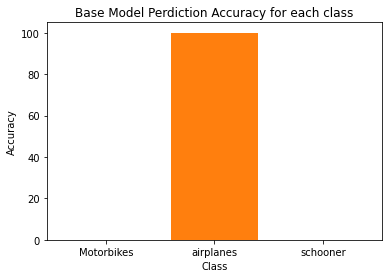

In [ ]:
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in dataloaders['val']: # Modification to map dataloader
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
first_model_accuracy = 100 * correct // total # Modification
print("Accuracy of the First Network on the validation images:", first_model_accuracy ,'%') # Modification
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in dataloaders['val']: # Modification to map dataloader
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    class_accuracy = 100 * float(correct_count) / total_pred[classname] # Modification to map dataloader
    print(f'Accuracy for class: {classname:5s} is {class_accuracy:.1f} %')

    # Plot graph for each class Airplane, Motorbikes, Schooner
    plt.title("Base Model Perdiction Accuracy for each class")
    plt.xlabel("Class")
    plt.ylabel("Accuracy")
    plt.bar(classname, class_accuracy)


In [ ]:
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)
import torch.nn as nn
import torch.nn.functional as F


class Model1Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 6) # Modification to Hyper-Parameters 
        self.pool = nn.AdaptiveAvgPool2d(6)
        self.conv2 = nn.Conv2d(16, 32, 6) # Modification to Hyper-Parameters
        self.fc1 = nn.Linear(32 * 6 * 6, 120) # Modification to Hyper-Parameters
        self.fc2 = nn.Linear(120, 60) # Modification to Hyper-Parameters
        self.fc3 = nn.Linear(60, 10) # Modification to Hyper-Parameters

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model1net = Model1Net()
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model1net.parameters(), lr=0.001, momentum=0.9)
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)
for epoch in range(5):  # let's run for 5 epochs 

    running_loss = 0.0
    for i, data in enumerate(dataloaders['train'], 0): # Modification to map dataloader
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model1net(inputs) # Modification to map to Model 1 
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print(f'[epoch : {epoch + 1}, mini-batches : {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training Model 1')

[epoch : 1, mini-batches :   100] loss: 0.100
[epoch : 2, mini-batches :   100] loss: 0.041
[epoch : 3, mini-batches :   100] loss: 0.026
[epoch : 4, mini-batches :   100] loss: 0.021
[epoch : 5, mini-batches :   100] loss: 0.021
Finished Training Model 1


Accuracy of the Second Network on the validation images: 88 %
Accuracy for class: Motorbikes is 82.8 %
Accuracy for class: airplanes is 98.1 %
Accuracy for class: schooner is 0.0 %


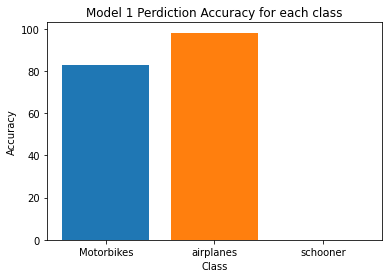

In [ ]:
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in dataloaders['val']: # Modification to map dataloader
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model1net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
second_model_accuracy = 100 * correct // total
print("Accuracy of the Second Network on the validation images:", second_model_accuracy ,'%')
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in dataloaders['val']: # Modification to map dataloader
        images, labels = data
        outputs = model1net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    class_accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {class_accuracy:.1f} %')

    # Plot graph for each class Airplane, Motorbikes, Schooner
    plt.title("Model 1 Perdiction Accuracy for each class")
    plt.xlabel("Class")
    plt.ylabel("Accuracy")
    plt.bar(classname, class_accuracy)

In [ ]:
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)
import torch.nn as nn
import torch.nn.functional as F


class Model2Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 6) # Modification to Hyper-Parameters 
        self.pool = nn.AdaptiveAvgPool2d(6)
        self.conv2 = nn.Conv2d(6, 12, 6) # Modification to Hyper-Parameters
        self.conv3 = nn.Conv2d(12, 24, 6) # Modification to Hyper-Parameters
        self.conv4 = nn.Conv2d(24, 48, 6) # Modification to Hyper-Parameters
        self.conv5 = nn.Conv2d(48, 96, 6) # Modification to Hyper-Parameters
        self.fc1 = nn.Linear(96 * 6 * 6, 160) # Modification to Hyper-Parameters
        self.fc2 = nn.Linear(160, 60) # Modification to Hyper-Parameters
        self.fc3 = nn.Linear(60, 10) # Modification to Hyper-Parameters

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model2net = Model2Net()
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model2net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(10):  # let's run for 5 epochs 

    running_loss = 0.0
    for i, data in enumerate(dataloaders['train'], 0): # Modification to map dataloader
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model2net(inputs) # Modification to map to Model 1 
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print(f'[epoch : {epoch + 1}, mini-batches : {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training Model 2')

[epoch : 1, mini-batches :   100] loss: 0.106
[epoch : 2, mini-batches :   100] loss: 0.051
[epoch : 3, mini-batches :   100] loss: 0.043
[epoch : 4, mini-batches :   100] loss: 0.040
[epoch : 5, mini-batches :   100] loss: 0.032
[epoch : 6, mini-batches :   100] loss: 0.027
[epoch : 7, mini-batches :   100] loss: 0.027
[epoch : 8, mini-batches :   100] loss: 0.023
[epoch : 9, mini-batches :   100] loss: 0.019
[epoch : 10, mini-batches :   100] loss: 0.019
Finished Training Model 2


Accuracy of the Third Network on the validation images: 89 %
Accuracy for class: Motorbikes is 84.0 %
Accuracy for class: airplanes is 100.0 %
Accuracy for class: schooner is 0.0 %


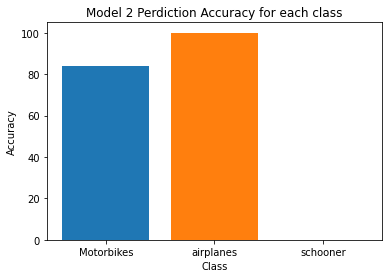

In [ ]:
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in dataloaders['val']: # Modification to map dataloader
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model2net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
third_model_accuracy = 100 * correct // total
print("Accuracy of the Third Network on the validation images:", third_model_accuracy ,'%')
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in dataloaders['val']: # Modification to map dataloader
        images, labels = data
        outputs = model2net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    class_accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {class_accuracy:.1f} %')

    # Plot graph for each class Airplane, Motorbikes, Schooner
    plt.title("Model 2 Perdiction Accuracy for each class")
    plt.xlabel("Class")
    plt.ylabel("Accuracy")
    plt.bar(classname, class_accuracy)

In [ ]:
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)
import torch.nn as nn
import torch.nn.functional as F


class Model3Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 6) # Modification to Hyper-Parameters 
        self.pool = nn.AdaptiveAvgPool2d(6) # Modification 
        self.conv2 = nn.Conv2d(6, 12, 6) # Modification to Hyper-Parameters
        self.conv3 = nn.Conv2d(12, 24, 6) # Modification to Hyper-Parameters
        self.conv4 = nn.Conv2d(24, 48, 6) # Addition of layer
        self.conv5 = nn.Conv2d(48, 96, 6) # Addition of layer
        self.conv6 = nn.Conv2d(96, 192, 6) # Addition of layer
        self.conv7 = nn.Conv2d(192, 384, 6) # Addition of layer
        self.conv8 = nn.Conv2d(384, 768, 6) # Addition of layer
        self.fc1 = nn.Linear(768 * 6 * 6, 512) # Modification to Hyper-Parameters
        self.fc2 = nn.Linear(512, 256) # Modification to Hyper-Parameters
        self.fc3 = nn.Linear(256, 128) # Modification to Hyper-Parameters
        self.fc4 = nn.Linear(128, 10) # Addition of layer

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = self.pool(F.relu(self.conv6(x)))
        x = self.pool(F.relu(self.conv7(x)))
        x = self.pool(F.relu(self.conv8(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x)) # Modification 
        x = self.fc4(x)
        return x


model3net = Model3Net()
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model3net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(10):  # let's run for 5 epochs 

    running_loss = 0.0
    for i, data in enumerate(dataloaders['train'], 0): # Modification to map dataloader
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model3net(inputs) # Modification to map to Model 1 
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print(f'[epoch : {epoch + 1}, mini-batches : {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training Model 3')

[epoch : 1, mini-batches :   100] loss: 0.105
[epoch : 2, mini-batches :   100] loss: 0.080
[epoch : 3, mini-batches :   100] loss: 0.060
[epoch : 4, mini-batches :   100] loss: 0.049
[epoch : 5, mini-batches :   100] loss: 0.044
[epoch : 6, mini-batches :   100] loss: 0.044
[epoch : 7, mini-batches :   100] loss: 0.043
[epoch : 8, mini-batches :   100] loss: 0.040
[epoch : 9, mini-batches :   100] loss: 0.030
[epoch : 10, mini-batches :   100] loss: 0.024
Finished Training Model 3


Accuracy of the Fourth Network on the validation images: 89 %
Accuracy for class: Motorbikes is 87.1 %
Accuracy for class: airplanes is 96.9 %
Accuracy for class: schooner is 0.0 %


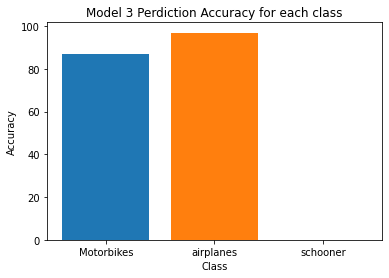

In [ ]:
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in dataloaders['val']: # Modification to map dataloader
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model3net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
fourth_model_accuracy = 100 * correct // total
print("Accuracy of the Fourth Network on the validation images:", fourth_model_accuracy ,'%')
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in dataloaders['val']: # Modification to map dataloader
        images, labels = data
        outputs = model3net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    class_accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {class_accuracy:.1f} %')

    # Plot graph for each class Airplane, Motorbikes, Schooner
    plt.title("Model 3 Perdiction Accuracy for each class")
    plt.xlabel("Class")
    plt.ylabel("Accuracy")
    plt.bar(classname, class_accuracy)

<BarContainer object of 4 artists>

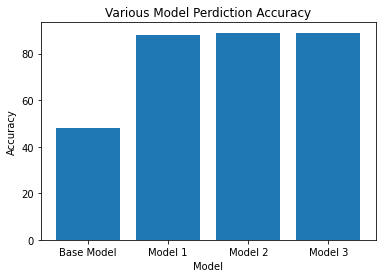

In [ ]:
# Plot graph for each class Airplane, Motorbikes, Schooner
plt.title("Various Model Perdiction Accuracy")
plt.xlabel("Model")
plt.ylabel("Accuracy")
x = ["Base Model", "Model 1", "Model 2", "Model 3"]
y = [first_model_accuracy,second_model_accuracy,third_model_accuracy,fourth_model_accuracy]
plt.bar(x, y)

In [ ]:
#Reference : (https://discuss.pytorch.org/t/how-to-split-dataset-into-test-and-validation-sets/33987/4)
def train_val_dataset(dataset, val_split=0.20):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

dataset = ImageFolder(img_data_dir, transform=Compose([
        transforms.Resize((300,300)),
        transforms.GaussianBlur(1,sigma=(0.1,0.5)),
        transforms.RandomRotation(5),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ]))
print("Total Number of Images",len(dataset))
datasets = train_val_dataset(dataset)
print("Total Number of Images in Training Dataset ",len(datasets['train']))
print("Total Number of Images in Validation Dataset ",len(datasets['val']))
print("Dataset Information ",datasets['train'].dataset)

dataloaders = {x:DataLoader(datasets[x],6, shuffle=True) for x in ['train','val']}
x,y = next(iter(dataloaders['train']))
print(x.shape, y.shape)

Total Number of Images 1661
Total Number of Images in Training Dataset  1328
Total Number of Images in Validation Dataset  333
Dataset Information  Dataset ImageFolder
    Number of datapoints: 1661
    Root location: caltech101_classification
    StandardTransform
Transform: Compose(
               Resize(size=(300, 300), interpolation=bilinear, max_size=None, antialias=None)
               GaussianBlur(kernel_size=(1, 1), sigma=(0.1, 0.5))
               RandomRotation(degrees=[-5.0, 5.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
torch.Size([6, 3, 300, 300]) torch.Size([6])


('Motorbikes', 'airplanes', 'schooner')


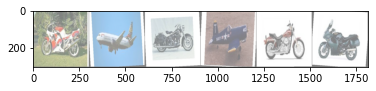

Motorbikes airplanes Motorbikes airplanes Motorbikes Motorbikes


In [ ]:
classes = ('Motorbikes', 'airplanes', 'schooner')
print(classes)
batch_size = 6
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(dataloaders['train']) # Modification to map dataloader
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

[epoch : 1, mini-batches :   100] loss: 2.062
[epoch : 1, mini-batches :   200] loss: 1.337
[epoch : 2, mini-batches :   100] loss: 0.905
[epoch : 2, mini-batches :   200] loss: 0.807
Finished Training Base Model


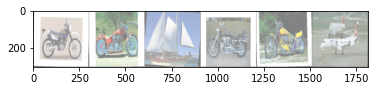

GroundTruth:  Motorbikes Motorbikes schooner Motorbikes Motorbikes airplanes
Predicted:  Motorbikes Motorbikes Motorbikes Motorbikes Motorbikes Motorbikes


In [ ]:
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)
import torch.nn as nn
import torch.nn.functional as F


class BaseNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.pool = nn.AdaptiveAvgPool2d(3)
        self.conv2 = nn.Conv2d(6, 12, 3)
        self.fc1 = nn.Linear(12 * 3 * 3, 240)
        self.fc2 = nn.Linear(240, 120)
        self.fc3 = nn.Linear(120, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = BaseNet()
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(dataloaders['train'], 0): # Modification to map dataloader
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 2000 mini-batches
            print(f'[epoch : {epoch + 1}, mini-batches : {i + 1:5d}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

print('Finished Training Base Model')
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)
PATH = './image_classifier.pth'
torch.save(net.state_dict(), PATH)
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)

dataiter = iter(dataloaders['train']) # Modification to map dataloader
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(6)))
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)
net = BaseNet()
net.load_state_dict(torch.load(PATH))
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)

outputs = net(images)
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(6)))

Accuracy of the First Network on the validation images: 47 %
Accuracy for class: Motorbikes is 100.0 %
Accuracy for class: airplanes is 0.0 %
Accuracy for class: schooner is 0.0 %


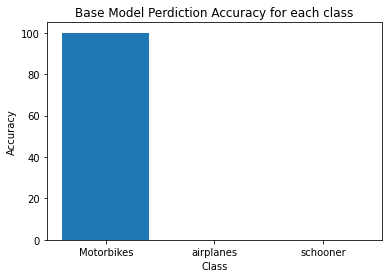

In [ ]:
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in dataloaders['val']: # Modification to map dataloader
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
first_model_accuracy = 100 * correct // total # Modification
print("Accuracy of the First Network on the validation images:", first_model_accuracy ,'%') # Modification
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in dataloaders['val']: # Modification to map dataloader
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    class_accuracy = 100 * float(correct_count) / total_pred[classname] # Modification to map dataloader
    print(f'Accuracy for class: {classname:5s} is {class_accuracy:.1f} %')

    # Plot graph for each class Airplane, Motorbikes, Schooner
    plt.title("Base Model Perdiction Accuracy for each class")
    plt.xlabel("Class")
    plt.ylabel("Accuracy")
    plt.bar(classname, class_accuracy)


In [ ]:
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)
import torch.nn as nn
import torch.nn.functional as F


class Model1Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 6) # Modification to Hyper-Parameters 
        self.pool = nn.AdaptiveAvgPool2d(6)
        self.conv2 = nn.Conv2d(16, 32, 6) # Modification to Hyper-Parameters
        self.fc1 = nn.Linear(32 * 6 * 6, 120) # Modification to Hyper-Parameters
        self.fc2 = nn.Linear(120, 60) # Modification to Hyper-Parameters
        self.fc3 = nn.Linear(60, 10) # Modification to Hyper-Parameters

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model1net = Model1Net()
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model1net.parameters(), lr=0.001, momentum=0.9)
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)
for epoch in range(5):  # let's run for 5 epochs 

    running_loss = 0.0
    for i, data in enumerate(dataloaders['train'], 0): # Modification to map dataloader
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model1net(inputs) # Modification to map to Model 1 
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print(f'[epoch : {epoch + 1}, mini-batches : {i + 1:5d}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

print('Finished Training Model 1')

[epoch : 1, mini-batches :   100] loss: 1.618
[epoch : 1, mini-batches :   200] loss: 0.860
[epoch : 2, mini-batches :   100] loss: 0.787
[epoch : 2, mini-batches :   200] loss: 0.490
[epoch : 3, mini-batches :   100] loss: 0.483
[epoch : 3, mini-batches :   200] loss: 0.510
[epoch : 4, mini-batches :   100] loss: 0.400
[epoch : 4, mini-batches :   200] loss: 0.420
[epoch : 5, mini-batches :   100] loss: 0.371
[epoch : 5, mini-batches :   200] loss: 0.376
Finished Training Model 1


Accuracy of the Second Network on the validation images: 83 %
Accuracy for class: Motorbikes is 70.9 %
Accuracy for class: airplanes is 98.8 %
Accuracy for class: schooner is 30.0 %


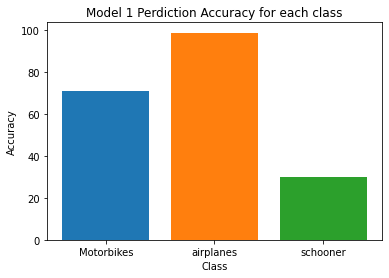

In [ ]:
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in dataloaders['val']: # Modification to map dataloader
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model1net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
second_model_accuracy = 100 * correct // total
print("Accuracy of the Second Network on the validation images:", second_model_accuracy ,'%')
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in dataloaders['val']: # Modification to map dataloader
        images, labels = data
        outputs = model1net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    class_accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {class_accuracy:.1f} %')

    # Plot graph for each class Airplane, Motorbikes, Schooner
    plt.title("Model 1 Perdiction Accuracy for each class")
    plt.xlabel("Class")
    plt.ylabel("Accuracy")
    plt.bar(classname, class_accuracy)

In [ ]:
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)
import torch.nn as nn
import torch.nn.functional as F


class Model2Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 6) # Modification to Hyper-Parameters 
        self.pool = nn.AdaptiveAvgPool2d(6)
        self.conv2 = nn.Conv2d(6, 12, 6) # Modification to Hyper-Parameters
        self.conv3 = nn.Conv2d(12, 24, 6) # Modification to Hyper-Parameters
        self.conv4 = nn.Conv2d(24, 48, 6) # Modification to Hyper-Parameters
        self.conv5 = nn.Conv2d(48, 96, 6) # Modification to Hyper-Parameters
        self.fc1 = nn.Linear(96 * 6 * 6, 160) # Modification to Hyper-Parameters
        self.fc2 = nn.Linear(160, 60) # Modification to Hyper-Parameters
        self.fc3 = nn.Linear(60, 10) # Modification to Hyper-Parameters

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model2net = Model2Net()
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model2net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(10):  # let's run for 5 epochs 

    running_loss = 0.0
    for i, data in enumerate(dataloaders['train'], 0): # Modification to map dataloader
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model2net(inputs) # Modification to map to Model 1 
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print(f'[epoch : {epoch + 1}, mini-batches : {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training Model 2')

[epoch : 1, mini-batches :   100] loss: 0.108
[epoch : 1, mini-batches :   200] loss: 0.089
[epoch : 2, mini-batches :   100] loss: 0.046
[epoch : 2, mini-batches :   200] loss: 0.042
[epoch : 3, mini-batches :   100] loss: 0.041
[epoch : 3, mini-batches :   200] loss: 0.037
[epoch : 4, mini-batches :   100] loss: 0.031
[epoch : 4, mini-batches :   200] loss: 0.030
[epoch : 5, mini-batches :   100] loss: 0.028
[epoch : 5, mini-batches :   200] loss: 0.023
[epoch : 6, mini-batches :   100] loss: 0.023
[epoch : 6, mini-batches :   200] loss: 0.022
[epoch : 7, mini-batches :   100] loss: 0.022
[epoch : 7, mini-batches :   200] loss: 0.024
[epoch : 8, mini-batches :   100] loss: 0.019
[epoch : 8, mini-batches :   200] loss: 0.018
[epoch : 9, mini-batches :   100] loss: 0.020
[epoch : 9, mini-batches :   200] loss: 0.019
[epoch : 10, mini-batches :   100] loss: 0.019
[epoch : 10, mini-batches :   200] loss: 0.021
Finished Training Model 2


Accuracy of the Third Network on the validation images: 85 %
Accuracy for class: Motorbikes is 79.7 %
Accuracy for class: airplanes is 98.2 %
Accuracy for class: schooner is 0.0 %


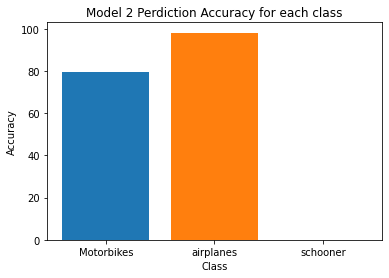

In [ ]:
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in dataloaders['val']: # Modification to map dataloader
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model2net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
third_model_accuracy = 100 * correct // total
print("Accuracy of the Third Network on the validation images:", third_model_accuracy ,'%')
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in dataloaders['val']: # Modification to map dataloader
        images, labels = data
        outputs = model2net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    class_accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {class_accuracy:.1f} %')

    # Plot graph for each class Airplane, Motorbikes, Schooner
    plt.title("Model 2 Perdiction Accuracy for each class")
    plt.xlabel("Class")
    plt.ylabel("Accuracy")
    plt.bar(classname, class_accuracy)

In [ ]:
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)
import torch.nn as nn
import torch.nn.functional as F


class Model3Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 6) # Modification to Hyper-Parameters 
        self.pool = nn.AdaptiveAvgPool2d(6) # Modification 
        self.conv2 = nn.Conv2d(6, 12, 6) # Modification to Hyper-Parameters
        self.conv3 = nn.Conv2d(12, 24, 6) # Modification to Hyper-Parameters
        self.conv4 = nn.Conv2d(24, 48, 6) # Addition of layer
        self.conv5 = nn.Conv2d(48, 96, 6) # Addition of layer
        self.conv6 = nn.Conv2d(96, 192, 6) # Addition of layer
        self.conv7 = nn.Conv2d(192, 384, 6) # Addition of layer
        self.conv8 = nn.Conv2d(384, 768, 6) # Addition of layer
        self.fc1 = nn.Linear(768 * 6 * 6, 512) # Modification to Hyper-Parameters
        self.fc2 = nn.Linear(512, 256) # Modification to Hyper-Parameters
        self.fc3 = nn.Linear(256, 128) # Modification to Hyper-Parameters
        self.fc4 = nn.Linear(128, 10) # Addition of layer

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = self.pool(F.relu(self.conv6(x)))
        x = self.pool(F.relu(self.conv7(x)))
        x = self.pool(F.relu(self.conv8(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x)) # Modification 
        x = self.fc4(x)
        return x


model3net = Model3Net()
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model3net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(10):  # let's run for 5 epochs 

    running_loss = 0.0
    for i, data in enumerate(dataloaders['train'], 0): # Modification to map dataloader
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model3net(inputs) # Modification to map to Model 1 
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print(f'[epoch : {epoch + 1}, mini-batches : {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training Model 3')

[epoch : 1, mini-batches :   100] loss: 0.106
[epoch : 1, mini-batches :   200] loss: 0.086
[epoch : 2, mini-batches :   100] loss: 0.066
[epoch : 2, mini-batches :   200] loss: 0.054
[epoch : 3, mini-batches :   100] loss: 0.045
[epoch : 3, mini-batches :   200] loss: 0.043
[epoch : 4, mini-batches :   100] loss: 0.032
[epoch : 4, mini-batches :   200] loss: 0.031
[epoch : 5, mini-batches :   100] loss: 0.027
[epoch : 5, mini-batches :   200] loss: 0.026
[epoch : 6, mini-batches :   100] loss: 0.027
[epoch : 6, mini-batches :   200] loss: 0.022
[epoch : 7, mini-batches :   100] loss: 0.022
[epoch : 7, mini-batches :   200] loss: 0.019
[epoch : 8, mini-batches :   100] loss: 0.019
[epoch : 8, mini-batches :   200] loss: 0.018
[epoch : 9, mini-batches :   100] loss: 0.020
[epoch : 9, mini-batches :   200] loss: 0.020
[epoch : 10, mini-batches :   100] loss: 0.021
[epoch : 10, mini-batches :   200] loss: 0.018
Finished Training Model 3


Accuracy of the Fourth Network on the validation images: 88 %
Accuracy for class: Motorbikes is 84.2 %
Accuracy for class: airplanes is 98.2 %
Accuracy for class: schooner is 0.0 %


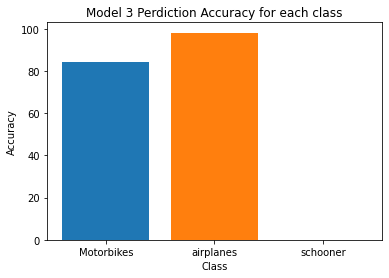

In [ ]:
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in dataloaders['val']: # Modification to map dataloader
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model3net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
fourth_model_accuracy = 100 * correct // total
print("Accuracy of the Fourth Network on the validation images:", fourth_model_accuracy ,'%')
# Reference : (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier)

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in dataloaders['val']: # Modification to map dataloader
        images, labels = data
        outputs = model3net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    class_accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {class_accuracy:.1f} %')

    # Plot graph for each class Airplane, Motorbikes, Schooner
    plt.title("Model 3 Perdiction Accuracy for each class")
    plt.xlabel("Class")
    plt.ylabel("Accuracy")
    plt.bar(classname, class_accuracy)

<BarContainer object of 4 artists>

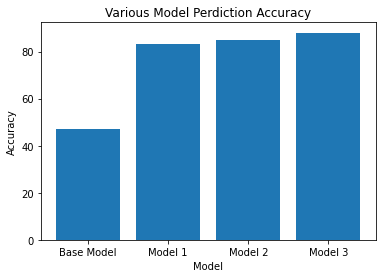

In [ ]:
# Plot graph for each class Airplane, Motorbikes, Schooner
plt.title("Various Model Perdiction Accuracy")
plt.xlabel("Model")
plt.ylabel("Accuracy")
x = ["Base Model", "Model 1", "Model 2", "Model 3"]
y = [first_model_accuracy,second_model_accuracy,third_model_accuracy,fourth_model_accuracy]
plt.bar(x, y)